# Interpreting the data
The ultimate goal of this study is to determine the oxygen saturation of dissolved hemoglobin in the phantoms. To do this, we will use the Hill equation, which relates the partial pressure of oxygen (i.e. oxygen tension) to the saturation of hemoglobin as follows:

$$
\text{sO}_2 = \frac{\text{pO}_2^h}{\text{p}_50^h + \text{pO}_2^h}
$$

The dissolved oxygen probe outputs data in the concentration with units of $\text{mg}/\text{mL}$. This must be converted to a partial pressure of oxygen. To determine the partial pressure of oxygen, we will use Henry's law:
$$
\text{pO}_2 = \frac{[\text{O}_2]}{k_H}
$$
In this equation, $k_H$ is Henry's law constant for the solution. This constant is not documented for solutions of hemoglobin and polystyrene micro-spheres. We will find it by first determine the local $\text{pO}_2$ by measuring the dissolved oxygen content of a pure water sample. We can use this same equation because Henry's law constant for water is well known. With $\text{pO}_2$ solved, we can rearrange Henry's law to find the constant for each phantom.

In [2]:
import sqlite3
import datetime

import numpy as np

from controllers.subs import update_plot

The data from the probe were written into a SQLite databse. We will read those back into the workspace as appropriate using SQLite syntax. In prep for that, we set up a connection to the database and a cursor for executing commands.

In [3]:
conn = sqlite3.connect('phantoms2.db')
c = conn.cursor()

Because the temperature is not constant, nor are probe readings perfect, we will perform our calculation at each captured point, then average those calculated values for further use.
$$
\text{pO}_2 = \frac{RT[\text{O}_2]_{\text{water}}}{H^{cc}}
$$

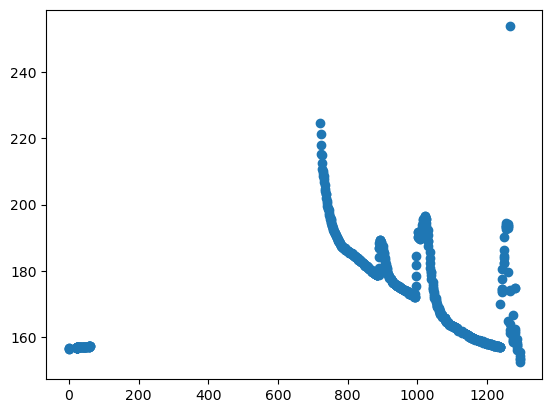

In [44]:
from matplotlib import pyplot as plt
from controllers.subs import update_plot
# Load water readings from database
c.execute("""SELECT time, dissolved_oxygen, temperature FROM phantom3_henry""")
data_queue = c.fetchall()
# data_queue = data_queue[700:1500]

fig, ax = plt.subplots()
# update_plot(fig, ax, data_queue)

# Extract time, dissolved oxygen, and temperature from data_queue
# Calculate pO2 for each reading
Hcc = 3.2e-2
R = 8314  # LPaK-1mol-1
m = 31.999  # g/mol
t0 = datetime.datetime.strptime(data_queue[0][0], '%Y-%m-%d %H:%M:%S')
times, do, T = zip(*data_queue)
times = [datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S') - t0 for t in times]
t = np.asarray([t.total_seconds() for t in times])
do = np.asarray(do) / 1000 / m  # mol/L
T = np.asarray(T) + 273.15  # K
kH = Hcc / (R * T)  # molL-1Pa-1
pO2 = 7.5 * (do / kH) / 1000  # mmHg

# Ensure data is sorted by time
sorted_data = sorted(zip(t, pO2), key=lambda x: x[0])
# Unpack sorted values
t, pO2 = zip(*sorted_data)
t = np.asarray(t)
pO2 = np.asarray(pO2)

h = 2.7
p50 = 27
sO2 = 100 * (pO2 ** h) / ((p50 ** h) + (pO2 ** h))

ax.scatter(t, pO2)
plt.show()

To check what a reasonable dissolved oxygen concentration would be, we can go the other way:
$$
[\text{O}_2] = \frac{H_{cc}\text{pO}_2}{RT}
$$
We will let temperature be 20$^\circ$C.

In [4]:
temp_range = np.asarray(range(15, 25, 1))
ideal_do = (Hcc * 21) / (R * (temp_range + 273.15)) * 1000 * m * 1000# Pa
plt.scatter(temp_range, ideal_do)
print(f'Dissolved oxygen expected around {ideal_do}.')

NameError: name 'Hcc' is not defined

In [40]:
c.execute("""SELECT name FROM sqlite_master WHERE type='table' AND name!='henry_constants_calculated' and name!='sqlite_sequence'""")
phantoms = c.fetchall()

In [42]:
c.execute("""CREATE TABLE IF NOT EXISTS henry_constants_calculated (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        phantom STRING NOT NULL,
        average_dot FLOAT NOT NULL,
        hcxx FLOAT NOT NULL,
        khx FLOAT NOT NULL)
        """)

TO = np.mean(T * do)  # Denominator with water values
Hcc_x = {}
for phantom in phantoms:
    phantom = phantom[0]
    c.execute(f"""SELECT dissolved_oxygen, temperature FROM {phantom}""")
    phantom_values = c.fetchall()
    do_x = np.asarray([val[0] / 1000 / m for val in phantom_values])
    T_x = np.asarray([val[1] + 273.15 for val in phantom_values])
    Hcc_x[phantom] = np.mean((Hcc * T_x * do_x) / TO)
    #
    # c.execute(f"""INSERT INTO henry_constants_calculated (phantom, average_dot, hcxx) VALUES (?, ?, ?)""",
    #           (phantom, do, Hcc_x[phantom]))
conn.commit()
for key, val in Hcc_x.items():
    print(key, val)

water_henry_constant 0.031999999999999994
phantom_water_cold 0.036341200187250566
phantom13_14 0.035324524058482416
phantom12 0.031897491892868876
phantom9 0.03375244641326695
phantom6 0.03516017557931591
phantom3 0.03995550021745918
